In [1]:
!pip install seaborn

In [2]:
import pandas as pd
import os

In [3]:
import pandas as pd
from pathlib import Path

# ---------- CONFIG ----------
BASE = "https://raw.githubusercontent.com/DieckmannDaniel/Git_energy_model/refs/heads/main/model_output"

# known files and separators
FILES = {
    "cost_breakdown.csv": "\t",
    "end_use.csv": "\t",
    "energy_output.csv": "\t",
    "gwp_breakdown.csv": "\t",
    "installed_technologies.csv": "\t",
    "losses.csv": "\t",
    "monthly_operation.csv": "\t",
    "performance.csv": "\t",
    "shares.csv": "\t",
    "storage.csv": "\t",
    "sankey/input2sankey.csv": ",",  # comma-separated, subfolder
}

def download_run_data(run_name: str, base: str = BASE) -> dict:
    """
    Downloads all model CSVs for a given run name into pandas DataFrames.
    Returns a dict like:
    {
        'TOTEX_min_baseline_cost_breakdown': DataFrame,
        'TOTEX_min_baseline_end_use': DataFrame,
        ...
    }
    """
    dfs = {}
    for rel_path, sep in FILES.items():
        url = f"{base.rstrip('/')}/{run_name}/{rel_path}"
        key = f"{run_name}_{Path(rel_path).stem}"  # e.g. TOTEX_min_baseline_cost_breakdown
        try:
            df = pd.read_csv(url, sep=sep, header=0)
            dfs[key] = df
            print(f"✅ Loaded: {key}")
        except Exception as e:
            print(f"[WARN] Could not load {url}: {e}")
    return dfs


In [4]:
if __name__ == "__main__":
    runs = ["TOTEX_min_baseline", "GWP_min_baseline_results"]

    all_data = {}
    for run in runs:
        all_data.update(download_run_data(run))

    # Example access:
    TOTEX_min_baseline_cost_breakdown = all_data["TOTEX_min_baseline_cost_breakdown"]
    display(TOTEX_min_baseline_cost_breakdown.head())

✅ Loaded: TOTEX_min_baseline_cost_breakdown
✅ Loaded: TOTEX_min_baseline_end_use
✅ Loaded: TOTEX_min_baseline_energy_output
✅ Loaded: TOTEX_min_baseline_gwp_breakdown
✅ Loaded: TOTEX_min_baseline_installed_technologies
✅ Loaded: TOTEX_min_baseline_losses
✅ Loaded: TOTEX_min_baseline_monthly_operation
✅ Loaded: TOTEX_min_baseline_performance
✅ Loaded: TOTEX_min_baseline_shares
✅ Loaded: TOTEX_min_baseline_storage
✅ Loaded: TOTEX_min_baseline_input2sankey
✅ Loaded: GWP_min_baseline_results_cost_breakdown
✅ Loaded: GWP_min_baseline_results_end_use
✅ Loaded: GWP_min_baseline_results_energy_output
✅ Loaded: GWP_min_baseline_results_gwp_breakdown
✅ Loaded: GWP_min_baseline_results_installed_technologies
✅ Loaded: GWP_min_baseline_results_losses
✅ Loaded: GWP_min_baseline_results_monthly_operation
✅ Loaded: GWP_min_baseline_results_performance
✅ Loaded: GWP_min_baseline_results_shares
✅ Loaded: GWP_min_baseline_results_storage
✅ Loaded: GWP_min_baseline_results_input2sankey


,Technology,C_inv [MCHF/y],C_maint [MCHF/y]
0,CCGT,88.985174,38.744015
1,PV,299.577580,250.771200
2,WIND,743.561476,169.460000
3,HYDRO_DAM,1905.444566,35.780227
4,HYDRO_RIVER,1140.409501,328.295917


In [5]:
all_data.keys()


dict_keys(['TOTEX_min_baseline_cost_breakdown', 'TOTEX_min_baseline_end_use', 'TOTEX_min_baseline_energy_output', 'TOTEX_min_baseline_gwp_breakdown', 'TOTEX_min_baseline_installed_technologies', 'TOTEX_min_baseline_losses', 'TOTEX_min_baseline_monthly_operation', 'TOTEX_min_baseline_performance', 'TOTEX_min_baseline_shares', 'TOTEX_min_baseline_storage', 'TOTEX_min_baseline_input2sankey', 'GWP_min_baseline_results_cost_breakdown', 'GWP_min_baseline_results_end_use', 'GWP_min_baseline_results_energy_output', 'GWP_min_baseline_results_gwp_breakdown', 'GWP_min_baseline_results_installed_technologies', 'GWP_min_baseline_results_losses', 'GWP_min_baseline_results_monthly_operation', 'GWP_min_baseline_results_performance', 'GWP_min_baseline_results_shares', 'GWP_min_baseline_results_storage', 'GWP_min_baseline_results_input2sankey'])

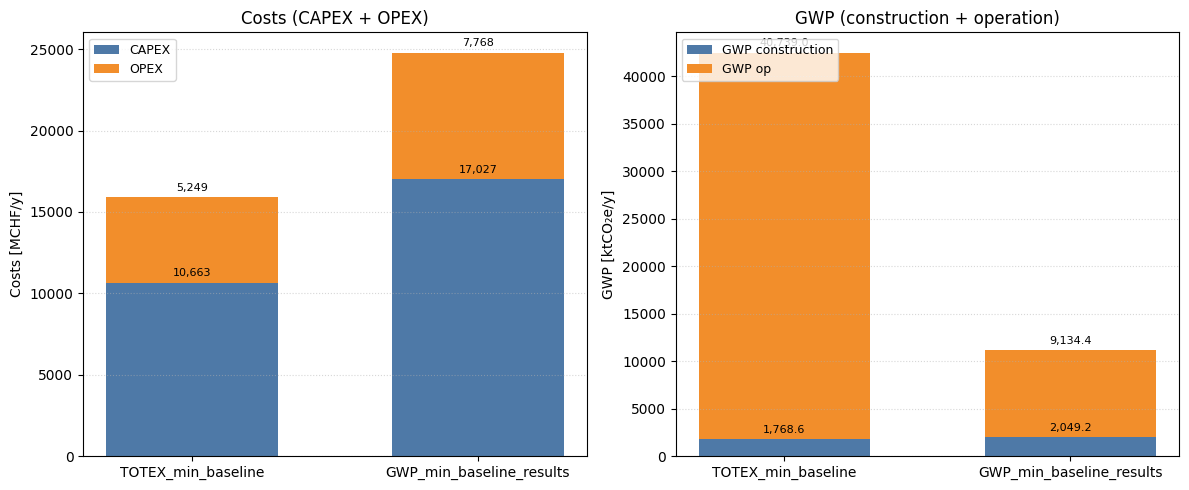

,CAPEX [MCHF/y],OPEX [MCHF/y],TOTEX [MCHF/y],GWP_construction [ktCO2e/y],GWP_op [ktCO2e/y],GWP_total [ktCO2e/y]
Model,,,,,,
TOTEX_min_baseline,10663.18,5248.96,15912.14,1768.57,40739.01,42507.58
GWP_min_baseline_results,17026.55,7768.27,24794.81,2049.20,9134.35,11183.56


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === SELECT WHICH PERFORMANCE DFs (keys in all_data) TO COMPARE ===
MODELS = [
    "TOTEX_min_baseline_performance",
    "GWP_min_baseline_results_performance",
]
# =================================================================

def _normalize_models(models):
    """Normalize model keys and nice display names."""
    out = []
    for m in models:
        if isinstance(m, tuple):
            out.append(m)
        else:
            name = m[:-12] if m.endswith("_performance") else m
            out.append((m, name))
    return out

def extract_from_performance_df(df: pd.DataFrame) -> dict:
    """
    Extract CAPEX, OPEX, TOTEX, and GWP values from a performance DataFrame.
    Works even if the file has two Value columns or repeated headers.
    """
    ind_col = next((c for c in df.columns if "indicator" in c.lower()), df.columns[0])
    value_cols = [c for c in df.columns if c != ind_col]

    # remove any duplicate header rows
    clean = df[df[ind_col].astype(str).str.lower() != "indicator"].copy()

    def get_val(indicator: str) -> float:
        rows = clean[clean[ind_col].astype(str).str.strip() == indicator]
        if rows.empty:
            return 0.0
        for c in value_cols:
            s = pd.to_numeric(rows[c], errors="coerce")
            if s.notna().any():
                return float(s.dropna().iloc[0])
        return 0.0

    return {
        "CAPEX [MCHF/y]": get_val("CAPEX"),
        "OPEX [MCHF/y]": get_val("OPEX"),
        "TOTEX [MCHF/y]": get_val("TOTEX"),
        # order follows CSV (construction → operation → total)
        "GWP_construction [ktCO2e/y]": get_val("GWP_construction"),
        "GWP_op [ktCO2e/y]": get_val("GWP_op"),
        "GWP_total [ktCO2e/y]": get_val("GWP_total"),
    }

# --- Build summary from all_data (no file I/O)
models = _normalize_models(MODELS)
summary_rows = []
for key, label in models:
    if key not in all_data:
        raise KeyError(f"'{key}' not found in all_data")
    df_perf = all_data[key]
    metrics = extract_from_performance_df(df_perf)
    metrics["Model"] = label
    summary_rows.append(metrics)

summary = pd.DataFrame(summary_rows).set_index("Model")

# --- Define categories (Costs + GWP)
cost_cats = ["CAPEX [MCHF/y]", "OPEX [MCHF/y]", "TOTEX [MCHF/y]"]
gwp_cats  = ["GWP_construction [ktCO2e/y]", "GWP_op [ktCO2e/y]", "GWP_total [ktCO2e/y]"]

# --- Generic stacked-bars helper (two components per model)
def plot_two_component_stack(ax, data, model_names, comp_bottom, comp_top, title, ylabel, fmt_bottom, fmt_top):
    x = np.arange(len(model_names))
    bar_w = 0.6

    # distinguishable component colors (fixed across models)
    bottom_color = "#4E79A7"  # CAPEX / GWP_construction
    top_color    = "#F28E2B"  # OPEX  / GWP_op

    handles = []

    for i, m in enumerate(model_names):
        v_bottom = float(data.loc[m, comp_bottom])
        v_top    = float(data.loc[m, comp_top])

        b = ax.bar(x[i], v_bottom, width=bar_w, color=bottom_color)
        t = ax.bar(x[i], v_top,    width=bar_w, bottom=v_bottom, color=top_color)

        # value labels on each segment
        if v_bottom != 0:
            ax.annotate(fmt_bottom(v_bottom),
                        (b[0].get_x() + b[0].get_width()/2, v_bottom),
                        textcoords="offset points", xytext=(0, 3),
                        ha="center", va="bottom", fontsize=8)
        if v_top != 0:
            ax.annotate(fmt_top(v_top),
                        (t[0].get_x() + t[0].get_width()/2, v_bottom + v_top),
                        textcoords="offset points", xytext=(0, 3),
                        ha="center", va="bottom", fontsize=8)

        if i == 0:
            handles = [b[0], t[0]]

    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=0)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis="y", linestyle=":", alpha=0.5)
    ax.legend(handles, [comp_bottom.split()[0].replace("GWP_", "GWP "),
                        comp_top.split()[0].replace("GWP_", "GWP ")],
              loc="upper left", fontsize=9)

# --- Create two subplots: Costs (left), GWP (right) — only stacked bars, no totals
model_names = list(summary.index)

fig, (ax_cost, ax_gwp) = plt.subplots(1, 2, figsize=(12, 5))

# Left: CAPEX + OPEX (TOTEX removed)
plot_two_component_stack(
    ax=ax_cost,
    data=summary,
    model_names=model_names,
    comp_bottom="CAPEX [MCHF/y]",
    comp_top="OPEX [MCHF/y]",
    title="Costs (CAPEX + OPEX)",
    ylabel="Costs [MCHF/y]",
    fmt_bottom=lambda v: f"{v:,.0f}",
    fmt_top=lambda v: f"{v:,.0f}",
)

# Right: GWP_construction + GWP_op (GWP_total removed)
plot_two_component_stack(
    ax=ax_gwp,
    data=summary,
    model_names=model_names,
    comp_bottom="GWP_construction [ktCO2e/y]",
    comp_top="GWP_op [ktCO2e/y]",
    title="GWP (construction + operation)",
    ylabel="GWP [ktCO₂e/y]",
    fmt_bottom=lambda v: f"{v:,.1f}",
    fmt_top=lambda v: f"{v:,.1f}",
)

plt.tight_layout()
plt.show()


# Optional: show numeric summary
summary


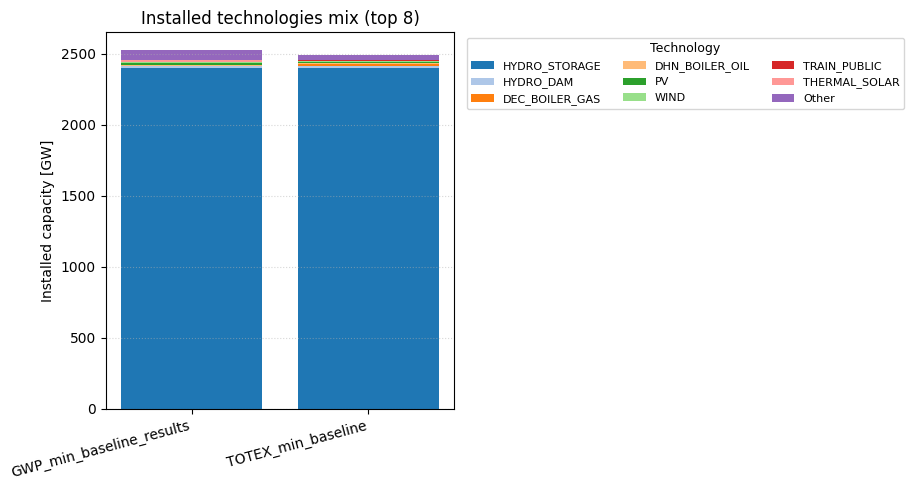

⚠️ Could not find resource-use tables in all_data for the selected models.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# ========== SETTINGS ==========
# The performance keys you’re already using for the cost/GWP plots:
MODELS = [
    "TOTEX_min_baseline_performance",
    "GWP_min_baseline_results_performance",
]

TOP_TECH_N = 8       # how many techs to show before grouping into "Other"
TOP_RES_N = 8        # how many resources to show before grouping into "Other"
# If your all_data keys don’t follow the usual pattern, you can override here:
KEY_OVERRIDES = {
    # "TOTEX_min_baseline": {
    #     "installed": "TOTEX_min_baseline_installed_technologies",
    #     "resources": "TOTEX_min_baseline_resources"
    # }
}
# =============================

def _base_name(perf_key: str) -> str:
    return perf_key[:-12] if perf_key.endswith("_performance") else perf_key

def _find_key_like(base: str, contains_patterns):
    """Find first key in all_data that starts with base and contains any pattern."""
    base_l = base.lower()
    candidates = []
    for k in all_data.keys():
        kl = k.lower()
        if kl.startswith(base_l):
            for pat in contains_patterns:
                if pat in kl:
                    candidates.append(k)
                    break
    # Prefer exact ‘installed_technologies’ or ‘resources’ if present
    priority = ["installed_technologies", "resources"]
    candidates = sorted(
        candidates,
        key=lambda x: (0 if any(p in x.lower() for p in priority) else 1, x)
    )
    return candidates[0] if candidates else None

def _get_installed_key(base: str):
    if base in KEY_OVERRIDES and "installed" in KEY_OVERRIDES[base]:
        return KEY_OVERRIDES[base]["installed"]
    return _find_key_like(base, ["installed", "install", "capacity"])

def _get_resources_key(base: str):
    if base in KEY_OVERRIDES and "resources" in KEY_OVERRIDES[base]:
        return KEY_OVERRIDES[base]["resources"]
    return _find_key_like(base, ["resource", "carrier", "fuel"])

def _pick_name_col(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    # fallback: first non-numeric column
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            return c
    return df.columns[0]

def _pick_value_col(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    # fallback: first numeric column
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    # fallback: coerce first column to numeric
    return df.columns[1] if len(df.columns) > 1 else df.columns[0]

def _extract_installed(df: pd.DataFrame):
    """
    Return (tech_name_col, cap_col, unit_label).
    Tries common headers like 'Technology' and 'Installed capacity [GW]'.
    """
    name_col = _pick_name_col(df, ["Technology", "technology", "Tech", "Name"])
    # common variants for capacity
    cap_cands = [
        "Installed capacity [GW]", "Installed capacity", "Installed_capacity_GW",
        "Capacity [GW]", "Capacity", "Installed [GW]"
    ]
    cap_col = _pick_value_col(df, [c for c in cap_cands if c in df.columns])
    # Try to detect units in brackets, else fallback
    unit = "GW"
    m = re.search(r"\[(.*?)\]", cap_col) if isinstance(cap_col, str) else None
    if m:
        unit = m.group(1)
    return name_col, cap_col, unit

def _extract_resources(df: pd.DataFrame):
    """
    Return (resource_col, qty_col, unit_label).
    Tries common headers like 'Resource' and 'Quantity [PJ/y]' or 'Quantity [MWh/y]'.
    """
    res_col = _pick_name_col(df, ["Resource", "Carrier", "Name"])
    qty_cands = [
        "Quantity [PJ/y]", "Quantity [MWh/y]", "Flow [PJ/y]", "Energy [MWh/y]", "Quantity"
    ]
    qty_col = _pick_value_col(df, [c for c in qty_cands if c in df.columns])
    unit = ""
    m = re.search(r"\[(.*?)\]", qty_col) if isinstance(qty_col, str) else None
    if m:
        unit = m.group(1)
    return res_col, qty_col, unit or "units"

# ------- Assemble combined tables across models -------
def _gather_installed(all_models):
    rows = []
    units = None
    for perf_key in all_models:
        base = _base_name(perf_key)
        inst_key = _get_installed_key(base)
        if inst_key is None or inst_key not in all_data:
            continue
        df = all_data[inst_key]
        name_col, cap_col, unit = _extract_installed(df)
        units = units or unit
        tmp = df[[name_col, cap_col]].copy()
        tmp.columns = ["Technology", "Value"]
        tmp["Model"] = base
        # coerce numeric
        tmp["Value"] = pd.to_numeric(tmp["Value"], errors="coerce").fillna(0.0)
        rows.append(tmp)
    if not rows:
        return None, None
    return pd.concat(rows, ignore_index=True), units

def _gather_resources(all_models):
    rows = []
    units = None
    for perf_key in all_models:
        base = _base_name(perf_key)
        res_key = _get_resources_key(base)
        if res_key is None or res_key not in all_data:
            continue
        df = all_data[res_key]
        res_col, qty_col, unit = _extract_resources(df)
        units = units or unit
        tmp = df[[res_col, qty_col]].copy()
        tmp.columns = ["Resource", "Value"]
        tmp["Model"] = base
        tmp["Value"] = pd.to_numeric(tmp["Value"], errors="coerce").fillna(0.0)
        rows.append(tmp)
    if not rows:
        return None, None
    return pd.concat(rows, ignore_index=True), units

models = MODELS  # performance keys
installed_df, installed_unit = _gather_installed(models)
resources_df, resources_unit = _gather_resources(models)

# ------- Plot helpers -------
def _stacked_topn(ax, df, group_col, label_col, value_col, top_n, title, ylabel, colors=None):
    """
    Make a stacked bar chart:
      x = models, stacks = top-N labels by total across all models (rest -> 'Other').
    """
    # total by label to find top-N
    totals = df.groupby(label_col, as_index=False)[value_col].sum().sort_values(value_col, ascending=False)
    top_labels = totals[label_col].head(top_n).tolist()
    df_plot = df.copy()
    df_plot[label_col] = df_plot[label_col].where(df_plot[label_col].isin(top_labels), other="Other")

    pivot = df_plot.pivot_table(
        index=group_col, columns=label_col, values=value_col, aggfunc="sum", fill_value=0.0
    ).sort_index()

    # consistent label order: top labels then 'Other'
    cols = [c for c in top_labels if c in pivot.columns]
    if "Other" in pivot.columns:
        cols.append("Other")
    pivot = pivot.reindex(columns=cols)

    # plot
    bottom = np.zeros(len(pivot))
    x = np.arange(len(pivot.index))
    if colors is None:
        colors = plt.cm.tab20.colors
    for i, lab in enumerate(pivot.columns):
        vals = pivot[lab].values
        ax.bar(x, vals, bottom=bottom, label=lab, color=colors[i % len(colors)])
        bottom += vals

    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=15, ha="right")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis="y", linestyle=":", alpha=0.5)
    return ax, pivot

# ------- Make the charts -------
plot_count = 0
if installed_df is not None and len(installed_df):
    fig1, ax1 = plt.subplots(figsize=(9, 5))
    _, installed_pivot = _stacked_topn(
        ax=ax1,
        df=installed_df,
        group_col="Model",
        label_col="Technology",
        value_col="Value",
        top_n=TOP_TECH_N,
        title=f"Installed technologies mix (top {TOP_TECH_N})",
        ylabel=f"Installed capacity [{installed_unit}]"
    )
    ax1.legend(title="Technology", ncols=3, fontsize=8, title_fontsize=9, loc="upper left", bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()
    plot_count += 1
else:
    print("⚠️ Could not find installed technologies tables in all_data for the selected models.")

if resources_df is not None and len(resources_df):
    fig2, ax2 = plt.subplots(figsize=(9, 5))
    _, resources_pivot = _stacked_topn(
        ax=ax2,
        df=resources_df,
        group_col="Model",
        label_col="Resource",
        value_col="Value",
        top_n=TOP_RES_N,
        title=f"Resource use mix (top {TOP_RES_N})",
        ylabel=f"Quantity [{resources_unit}]"
    )
    ax2.legend(title="Resource", ncols=3, fontsize=8, title_fontsize=9, loc="upper left", bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()
    plot_count += 1
else:
    print("⚠️ Could not find resource-use tables in all_data for the selected models.")

if plot_count == 0:
    print("No plots created. You may need to provide KEY_OVERRIDES for installed/resources tables or check all_data keys.")
